# The Drug Use Predictor

### Predicting the likelihood of illegal drug use based on personality and use of legal stimulants

Author: Melissa Burn\
Georgetown University School of Continuing Studies, Certificate in Data Science, Cohort 11 (Spring 2018)

Please see the associated README and LICENSE files in this directory for important information about this project

In [1]:
%matplotlib inline

import os
import pickle
import requests
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import sklearn
from sklearn import preprocessing, tree
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix, classification_report
from scipy import cluster
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
pd.options.mode.chained_assignment = None  # get rid of this pesky warning; default='warn'

### Project Workflow

This Notebook moves through the following steps to feed, run, test, and validate the model:
1. Ingest the required raw data into a dataframe
2. Wrangle the data to provide the right format and column structure and copy a subset of the dataframe, keeping the demographics, personality test scores, and reported use of legal intoxicants and stimulants
3. Look at the data using some simple correlations and visualizations to assess what's there
4. Create & refine the features list to use in the model, and build the target vector for training
5. Try three or more available classification models from Scikit-Learn, select one as the "best fit" predictor
6. Ingest a new dataset including the features required and run the prediction

### Data Ingestion

Grab the dataset from the UCI Machine Learning Repository and look it over.

In [2]:
# Location of the drug consumption data in the UCI machine learning Repo
URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00373/drug_consumption.data"

# Function to fetch the data from the UCI Repo and store it in a .txt file in the data subdir
def fetch_data(fname='data/drug_dataset.txt'):
    """
    Method to retrieve the ML Repository dataset.
    """
    response = requests.get(URL)
    outpath  = os.path.abspath(fname)
    with open(outpath, 'wb') as f:
        f.write(response.content)
    
    return outpath

DATA = fetch_data()

### Basis for personality assessment features used in the data

The research data were collected in 2016 by Fehrman (UK), who used the NEO 5-factor inventory to assess personality traits that might be associated with substance abuse. She also assessed respondents using the Barratt Impusliveness Scale.

FROM THE REFERENCE ARTICLE:

"The five factors are: N, E, O, A, and C with 12 items per domain. The five traits can be summarized as:

1. Neuroticism (NS) is a long-term tendency to experience negative emotions such as nervousness, tension, anxiety and depression;
2. Extraversion (ES) is manifested in outgoing, warm, active, assertive, talkative, cheerful, and in search of stimulation characteristics;
3. Openness to experience (OS) is a general appreciation for art, unusual ideas, and imaginative, creative, unconventional, and wide interests,
4. Agreeableness (AS) is a dimension of interpersonal relations, characterized by altruism, trust, modesty, kindness, compassion and cooperativeness;
5. Conscientiousness (CS) is a tendency to be organized and dependable, strong-willed, persistent, reliable, and efficient.

Participants were questioned concerning their use of 18 legal and illegal drugs (alcohol, amphetamines, amyl nitrite, benzodiazepines, cannabis, chocolate, cocaine, caffeine, crack, ecstasy, heroin, ketamine, legal highs, LSD, methadone, magic mushrooms, nicotine and volatile substance abuse (VSA)) and one fictitious drug (Semeron) which was introduced to identify over-claimers."

### Initial Thoughts

While the factors above may be distinct for the purpose of psychological assessment, they might be highly correlated for machine learning purposes and, so, not all give useful information. I'll need to examine them to see if the features should be combined, dropped, or supplemented.

In [3]:
# Create the features list using information from the UCI Data Set Description

FEATURES  = [
    "ID", # May not be used to identify respondents
    "Age", # 18-24, 25-34, 35-44, 45-54, 55-64, 65+
    "Gender", # Female, Male
    "Educ", # Left before age 16, left @ 16, @ 17, @ 18, some college, prof cert, univ degree, masters, doctorate
    "Cntry", # Country: AUS, CAN, NZ, Other, IRE, UK, USA
    "Ethn", # Ethnicity: Asian, Black, Mixed Bla/As, Mixed Whi/As, Mixed Whi/Bla, Other
    "NS",  # Neuroticism Score
    "ES",  # Extroversion Score
    "OS",  # Openness to experience Score
    "AS",  # Agreeableness Score
    "CS",  # Conscientiousness Score
    "Imp", # Impulsivity, Lickert scale with -3 = least impulsive, +3 = most impulsive
    "SS",  # Sensation seeking, part of the Impulsiveness assessment, -3 < score > +3
    "Alcohol", # Class of alcohol consumption
    "Amphet", # Class of amphetamine consumption
    "Amyl", # Class of amyl nitrite consumption
    "Benzos", # Class of benzodiazepine consumption
    "Caffeine", # Class of caffeine consumption
    "Cannabis", # Class of cannabis consumption
    "Choco", # Class of chocolate consumption
    "Coke", # Class of cocaine consumption
    "Crack", # Class of crack cocaine consumption
    "Ecstasy", # Class of ecstasy consumption
    "Heroin", # Class of heroin consumption
    "Ketamine", # Class of ketamine consumption
    "LegalH", # Class of legal highs consumption
    "LSD", # Class of LSD consumption
    "Meth", # Class of methamphetamine consumption
    "Shrooms", # Class of mushrooms consumption
    "Nicotine", # Class of nicotine consumption
    "Semer",# Class of fictitious drug Semeron consumption
    "VSA" # Class of volatile substance abuse consumption
]

USE_CLASSES = [
    "CL0",  # Never used this substance
    "CL1",  # Used over a decade ago
    "CL2",  # Used in last decade
    "CL3",  # Used in last year
    "CL4",  # Used in last month
    "CL5",  # Used in last week
    "CL6"   # Used in last day   
]

# Read the data into a DataFrame -- the Respondent characteristics are all integer or real 
df = pd.read_csv(DATA, sep=',', header=None, names=FEATURES)

# Determine the shape of the data
print("{} instances with {} features\n".format(*df.shape))

# I'd like to look at this data a little more
df.head()

1885 instances with 32 features



,ID,Age,Gender,Educ,Cntry,Ethn,NS,ES,OS,AS,...,Ecstasy,Heroin,Ketamine,LegalH,LSD,Meth,Shrooms,Nicotine,Semer,VSA
0,1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
1,2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
2,3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
3,4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
4,5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


In [4]:
df.index.values

array([   0,    1,    2, ..., 1882, 1883, 1884])

In [5]:
# Describe the dataset numeric features (won't include the drug use classes, which are still coded as text)
print(df.describe())

                ID         Age       Gender         Educ        Cntry  \
count  1885.000000  1885.00000  1885.000000  1885.000000  1885.000000   
mean    945.294960     0.03461    -0.000256    -0.003806     0.355542   
std     545.167641     0.87836     0.482588     0.950078     0.700335   
min       1.000000    -0.95197    -0.482460    -2.435910    -0.570090   
25%     474.000000    -0.95197    -0.482460    -0.611130    -0.570090   
50%     946.000000    -0.07854    -0.482460    -0.059210     0.960820   
75%    1417.000000     0.49788     0.482460     0.454680     0.960820   
max    1888.000000     2.59171     0.482460     1.984370     0.960820   

              Ethn           NS           ES           OS           AS  \
count  1885.000000  1885.000000  1885.000000  1885.000000  1885.000000   
mean     -0.309577     0.000047    -0.000163    -0.000534    -0.000245   
std       0.166226     0.998106     0.997448     0.996229     0.997440   
min      -1.107020    -3.464360    -3.273930  

### Preliminary Assessment

Based on the fact that all numeric data was coded by the UK researchers to be in the range -3 to 3, I don't think the dataset needs to be standardized or normalized. 

However, because I want to create a predictive model, and the most interesting thing (to me) to predict is drug usage, I need to create a target variable reflecting that. The simplest case is to use the demographic and personality data to make a guess, but I think peoples' use of socially-acceptable substances like nicotine and alcohol might also be useful for the prediction, so I'll keep those too in the feature set. 

The desired endstate for wrangling then is to keep all the potentially relevant features plus one target that reflects any illegal drug usage in the training dataset.

### Data Wrangling

Tasks being completed in this section include:
1. Convert the text variables CL0 - CL6 to numbers
2. Create a dataframe copy of just the features I intend as "input" for the predictor
3. Create one new target vector, WillUse, from all the illegal drug use variables in the original dataframe plus the technically legal but socially rejected LegalHigh

Note several versions of the dataframe:
- df = initial dataframe created from the UCI survey data
- dfcopy = copy of df with all drug use features converted from text to number format
- part_df = subset of dfcopy with the draft feature set for modeling (no "illegal" drugs features) plus the target, WillUse

In [6]:
# Preserve the original df but create a copy to work on
dfcopy = df

# Replace all the non-numeric features (14 - 32) with numbers, using a range consistent with other variables
dfcopy.replace(["CL0","CL1","CL2","CL3","CL4","CL5","CL6"],[-3.0,-2.0,-1.0,0.0,1.0,2.0,3.0],inplace=True)
dfcopy.head()


,ID,Age,Gender,Educ,Cntry,Ethn,NS,ES,OS,AS,...,Ecstasy,Heroin,Ketamine,LegalH,LSD,Meth,Shrooms,Nicotine,Semer,VSA
0,1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,...,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-1.0,-3.0,-3.0
1,2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,...,1.0,-3.0,-1.0,-3.0,-1.0,0.0,-3.0,1.0,-3.0,-3.0
2,3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,...,-3.0,-3.0,-3.0,-3.0,-3.0,-3.0,-2.0,-3.0,-3.0,-3.0
3,4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,...,-3.0,-3.0,-1.0,-3.0,-3.0,-3.0,-3.0,-1.0,-3.0,-3.0
4,5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,...,-2.0,-3.0,-3.0,-2.0,-3.0,-3.0,-1.0,-1.0,-3.0,-3.0


### Feature Exploration


In [7]:
# I need a copy of the dataframe that has the first 13 demographic and personality features, plus 
# the 4 responses indicating use of legal drugs (alcohol, caffeine, chocolate, and nicotine)
# NOTE: I'm treating "LegalHigh" as an illegal for assessing likelihood of illegal use

feature_names = ['Age','Gender','Educ','Cntry','Ethn','NS','ES','OS','AS','CS','Imp',\
                                    'SS',"Alcohol","Caffeine","Choco","Nicotine"]
part_df = pd.DataFrame.copy(dfcopy[feature_names])
print(part_df.head())

       Age   Gender     Educ    Cntry     Ethn       NS       ES       OS  \
0  0.49788  0.48246 -0.05921  0.96082  0.12600  0.31287 -0.57545 -0.58331   
1 -0.07854 -0.48246  1.98437  0.96082 -0.31685 -0.67825  1.93886  1.43533   
2  0.49788 -0.48246 -0.05921  0.96082 -0.31685 -0.46725  0.80523 -0.84732   
3 -0.95197  0.48246  1.16365  0.96082 -0.31685 -0.14882 -0.80615 -0.01928   
4  0.49788  0.48246  1.98437  0.96082 -0.31685  0.73545 -1.63340 -0.45174   

        AS       CS      Imp       SS  Alcohol  Caffeine  Choco  Nicotine  
0 -0.91699 -0.00665 -0.21712 -1.18084      2.0       3.0    2.0      -1.0  
1  0.76096 -0.14277 -0.71126 -0.21575      2.0       3.0    3.0       1.0  
2 -1.62090 -1.01450 -1.37983  0.40148      3.0       3.0    1.0      -3.0  
3  0.59042  0.58489 -1.37983 -1.18084      1.0       2.0    1.0      -1.0  
4 -0.30172  1.30612 -0.21712 -0.21575      1.0       3.0    3.0      -1.0  


In [8]:
# Checking the data characteristics of part_df
print(part_df.describe())

              Age       Gender         Educ        Cntry         Ethn  \
count  1885.00000  1885.000000  1885.000000  1885.000000  1885.000000   
mean      0.03461    -0.000256    -0.003806     0.355542    -0.309577   
std       0.87836     0.482588     0.950078     0.700335     0.166226   
min      -0.95197    -0.482460    -2.435910    -0.570090    -1.107020   
25%      -0.95197    -0.482460    -0.611130    -0.570090    -0.316850   
50%      -0.07854    -0.482460    -0.059210     0.960820    -0.316850   
75%       0.49788     0.482460     0.454680     0.960820    -0.316850   
max       2.59171     0.482460     1.984370     0.960820     1.907250   

                NS           ES           OS           AS           CS  \
count  1885.000000  1885.000000  1885.000000  1885.000000  1885.000000   
mean      0.000047    -0.000163    -0.000534    -0.000245    -0.000386   
std       0.998106     0.997448     0.996229     0.997440     0.997523   
min      -3.464360    -3.273930    -3.273930  

### Visualization

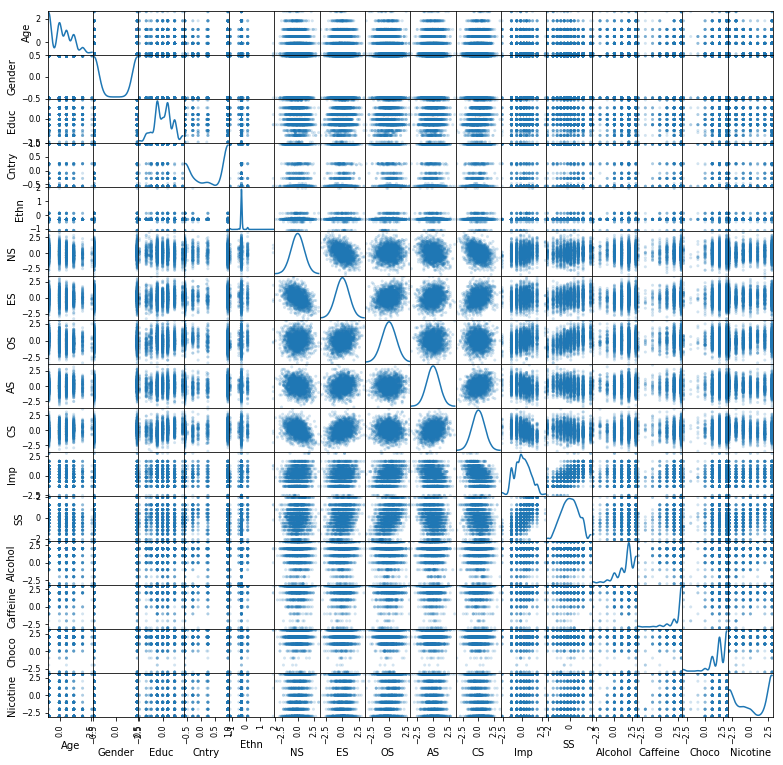

In [9]:
# Try a scatter matrix
scatter_matrix(part_df, alpha=0.2, figsize=(13, 13), diagonal='kde')
plt.show()

In [10]:
# I can't see any "screaming" patterns that jump out, but a good distribution is OK

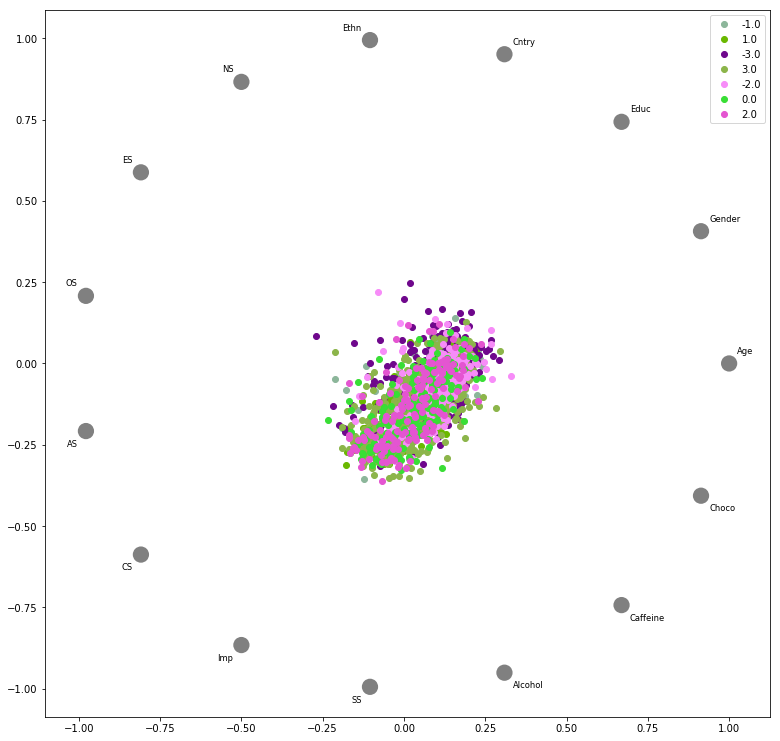

In [11]:
# Create a radial plot focusing on relationships to one feature
from pandas.plotting import radviz
plt.figure(figsize=(13,13))
pd.plotting.radviz(part_df, "Nicotine")
plt.show()

In [12]:
# The dots are pretty well mixed up. Not much hope of segregating them, based on this view. Keep going.

/Users/mac/anaconda3/lib/python3.6/site-packages/matplotlib/collections.py:853: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


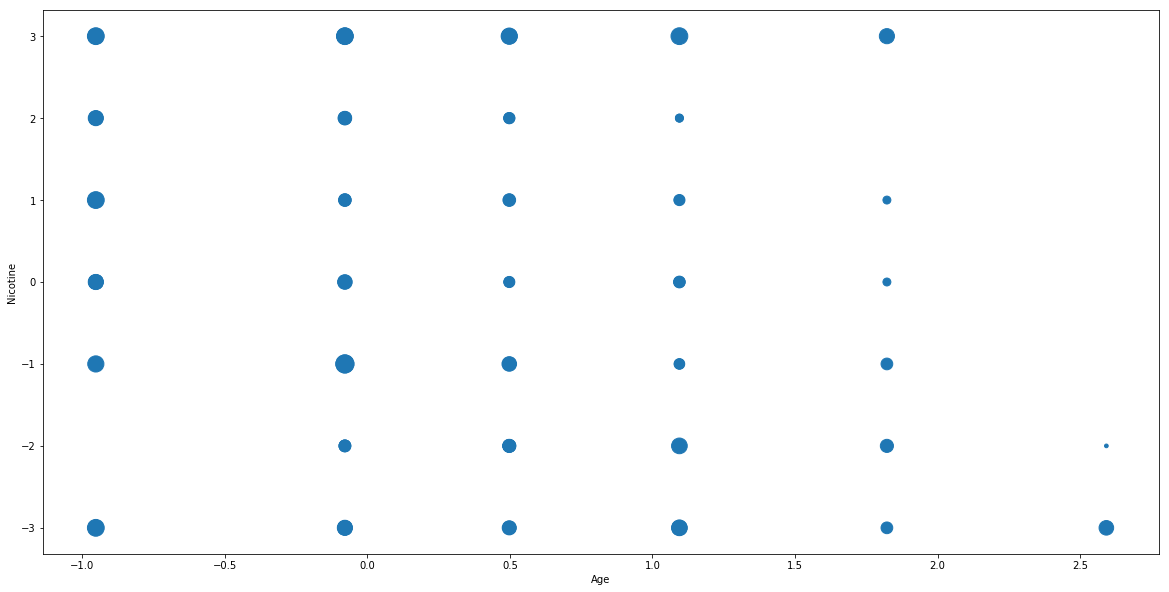

In [13]:
# Try a different scatter plot
part_df.plot(kind='scatter', x='Age', y='Nicotine', s=part_df['NS']*100,figsize=[20,10])

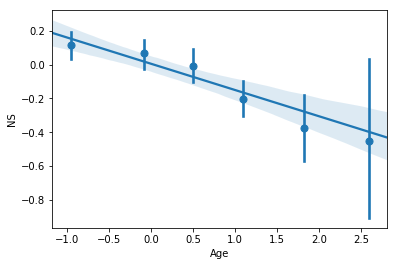

In [14]:
# Interesting that the size of the blobs (NS, negativity, anxiety) is high for all who smoke a lot. 
# Also seem to see a reduction in both smoking and blob density with age as though young people
# smoke more and are more NS = neurotic, negative, anxious, fearful. Wow!

# Try a different plot to see if increased age is associated with any change in cigarette smoking
sns.regplot(x='Age', y='NS', data=part_df, x_estimator=np.mean)

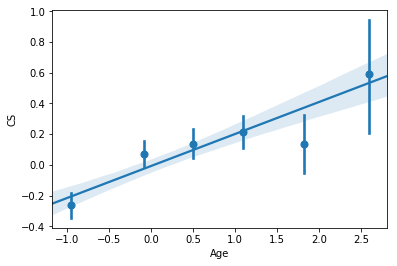

In [15]:
# So, older people are a little less "neurotic", though scatter increases with age. This is completely
# counter to popular perception of younger people being more optimistic until age hardens them. Wow!

# Is there anything that increases with age?
sns.regplot(x='Age', y='CS', data=part_df, x_estimator=np.mean)

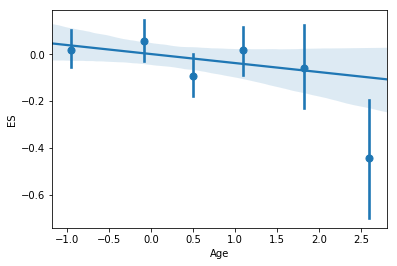

In [16]:
# So, conscientiousness increases with age, which is reassuring, and the scatter seems a little narrower

# Is there anything at all that varies LESS with age, or doesn't change?
sns.regplot(x='Age', y='ES', data=part_df, x_estimator=np.mean)

Hmmm. Apparently extroversion remains stable until it seems to drop for the oldest age group. Get off my lawn!!

### Target Development

Add "WillUse" column to part_df

Set drug use assessment as follows:
- = 0 for not likely to use
- = 1 for likely to use, 'WillUse'

Note: I'm treating LegalHighs as illegal since, as far as I know, they're not accepted as normal recreation in any community (as the other 4 are).

In [17]:
# Create a list of the illegal drug names. These are the responses I want to compress into one factor that 
# gets triggered if any of these are used within the past decade
drug_names = ["Amphet","Amyl","Benzos","Cannabis","Coke","Crack","Ecstasy","Heroin","Ketamine",
                           "LegalH","LSD","Meth","Shrooms","Semer","VSA"]

# To part_df, add a column for indicating illegal drug use (the target), set to zero ("not likely to use")
part_df["WillUse"] = int(0)

In [18]:
# Cycle through the instances and illegal drug name features to switch part_df['WillUse'] to 1 
# if any illegal drugs were used in the past decade

for i in dfcopy.index.values:
    count = -1
    while count < 14:
        count += 1
        # print('i is ', i, 'count is ', count)
        # check for illegal drug use within past decade or less
        if dfcopy.loc[i, drug_names[count]] > -2.0:
            # set the prediction to 1 = likely to use illegal drugs
            part_df.loc[[i],['WillUse']] = int(1)
            # print ("For i of ", i," target is switched to ", part_df.loc[[i],['WillUse']])
            break

In [19]:
print(part_df.describe())     # Check to see what this stuff looks like

              Age       Gender         Educ        Cntry         Ethn  \
count  1885.00000  1885.000000  1885.000000  1885.000000  1885.000000   
mean      0.03461    -0.000256    -0.003806     0.355542    -0.309577   
std       0.87836     0.482588     0.950078     0.700335     0.166226   
min      -0.95197    -0.482460    -2.435910    -0.570090    -1.107020   
25%      -0.95197    -0.482460    -0.611130    -0.570090    -0.316850   
50%      -0.07854    -0.482460    -0.059210     0.960820    -0.316850   
75%       0.49788     0.482460     0.454680     0.960820    -0.316850   
max       2.59171     0.482460     1.984370     0.960820     1.907250   

                NS           ES           OS           AS           CS  \
count  1885.000000  1885.000000  1885.000000  1885.000000  1885.000000   
mean      0.000047    -0.000163    -0.000534    -0.000245    -0.000386   
std       0.998106     0.997448     0.996229     0.997440     0.997523   
min      -3.464360    -3.273930    -3.273930  

In [20]:
# Judging from the mean of WillUse, quite a few of the respondents in the sample used in the past decade

# Basic data info
part_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1885 entries, 0 to 1884
Data columns (total 17 columns):
Age         1885 non-null float64
Gender      1885 non-null float64
Educ        1885 non-null float64
Cntry       1885 non-null float64
Ethn        1885 non-null float64
NS          1885 non-null float64
ES          1885 non-null float64
OS          1885 non-null float64
AS          1885 non-null float64
CS          1885 non-null float64
Imp         1885 non-null float64
SS          1885 non-null float64
Alcohol     1885 non-null float64
Caffeine    1885 non-null float64
Choco       1885 non-null float64
Nicotine    1885 non-null float64
WillUse     1885 non-null int64
dtypes: float64(16), int64(1)
memory usage: 250.4 KB


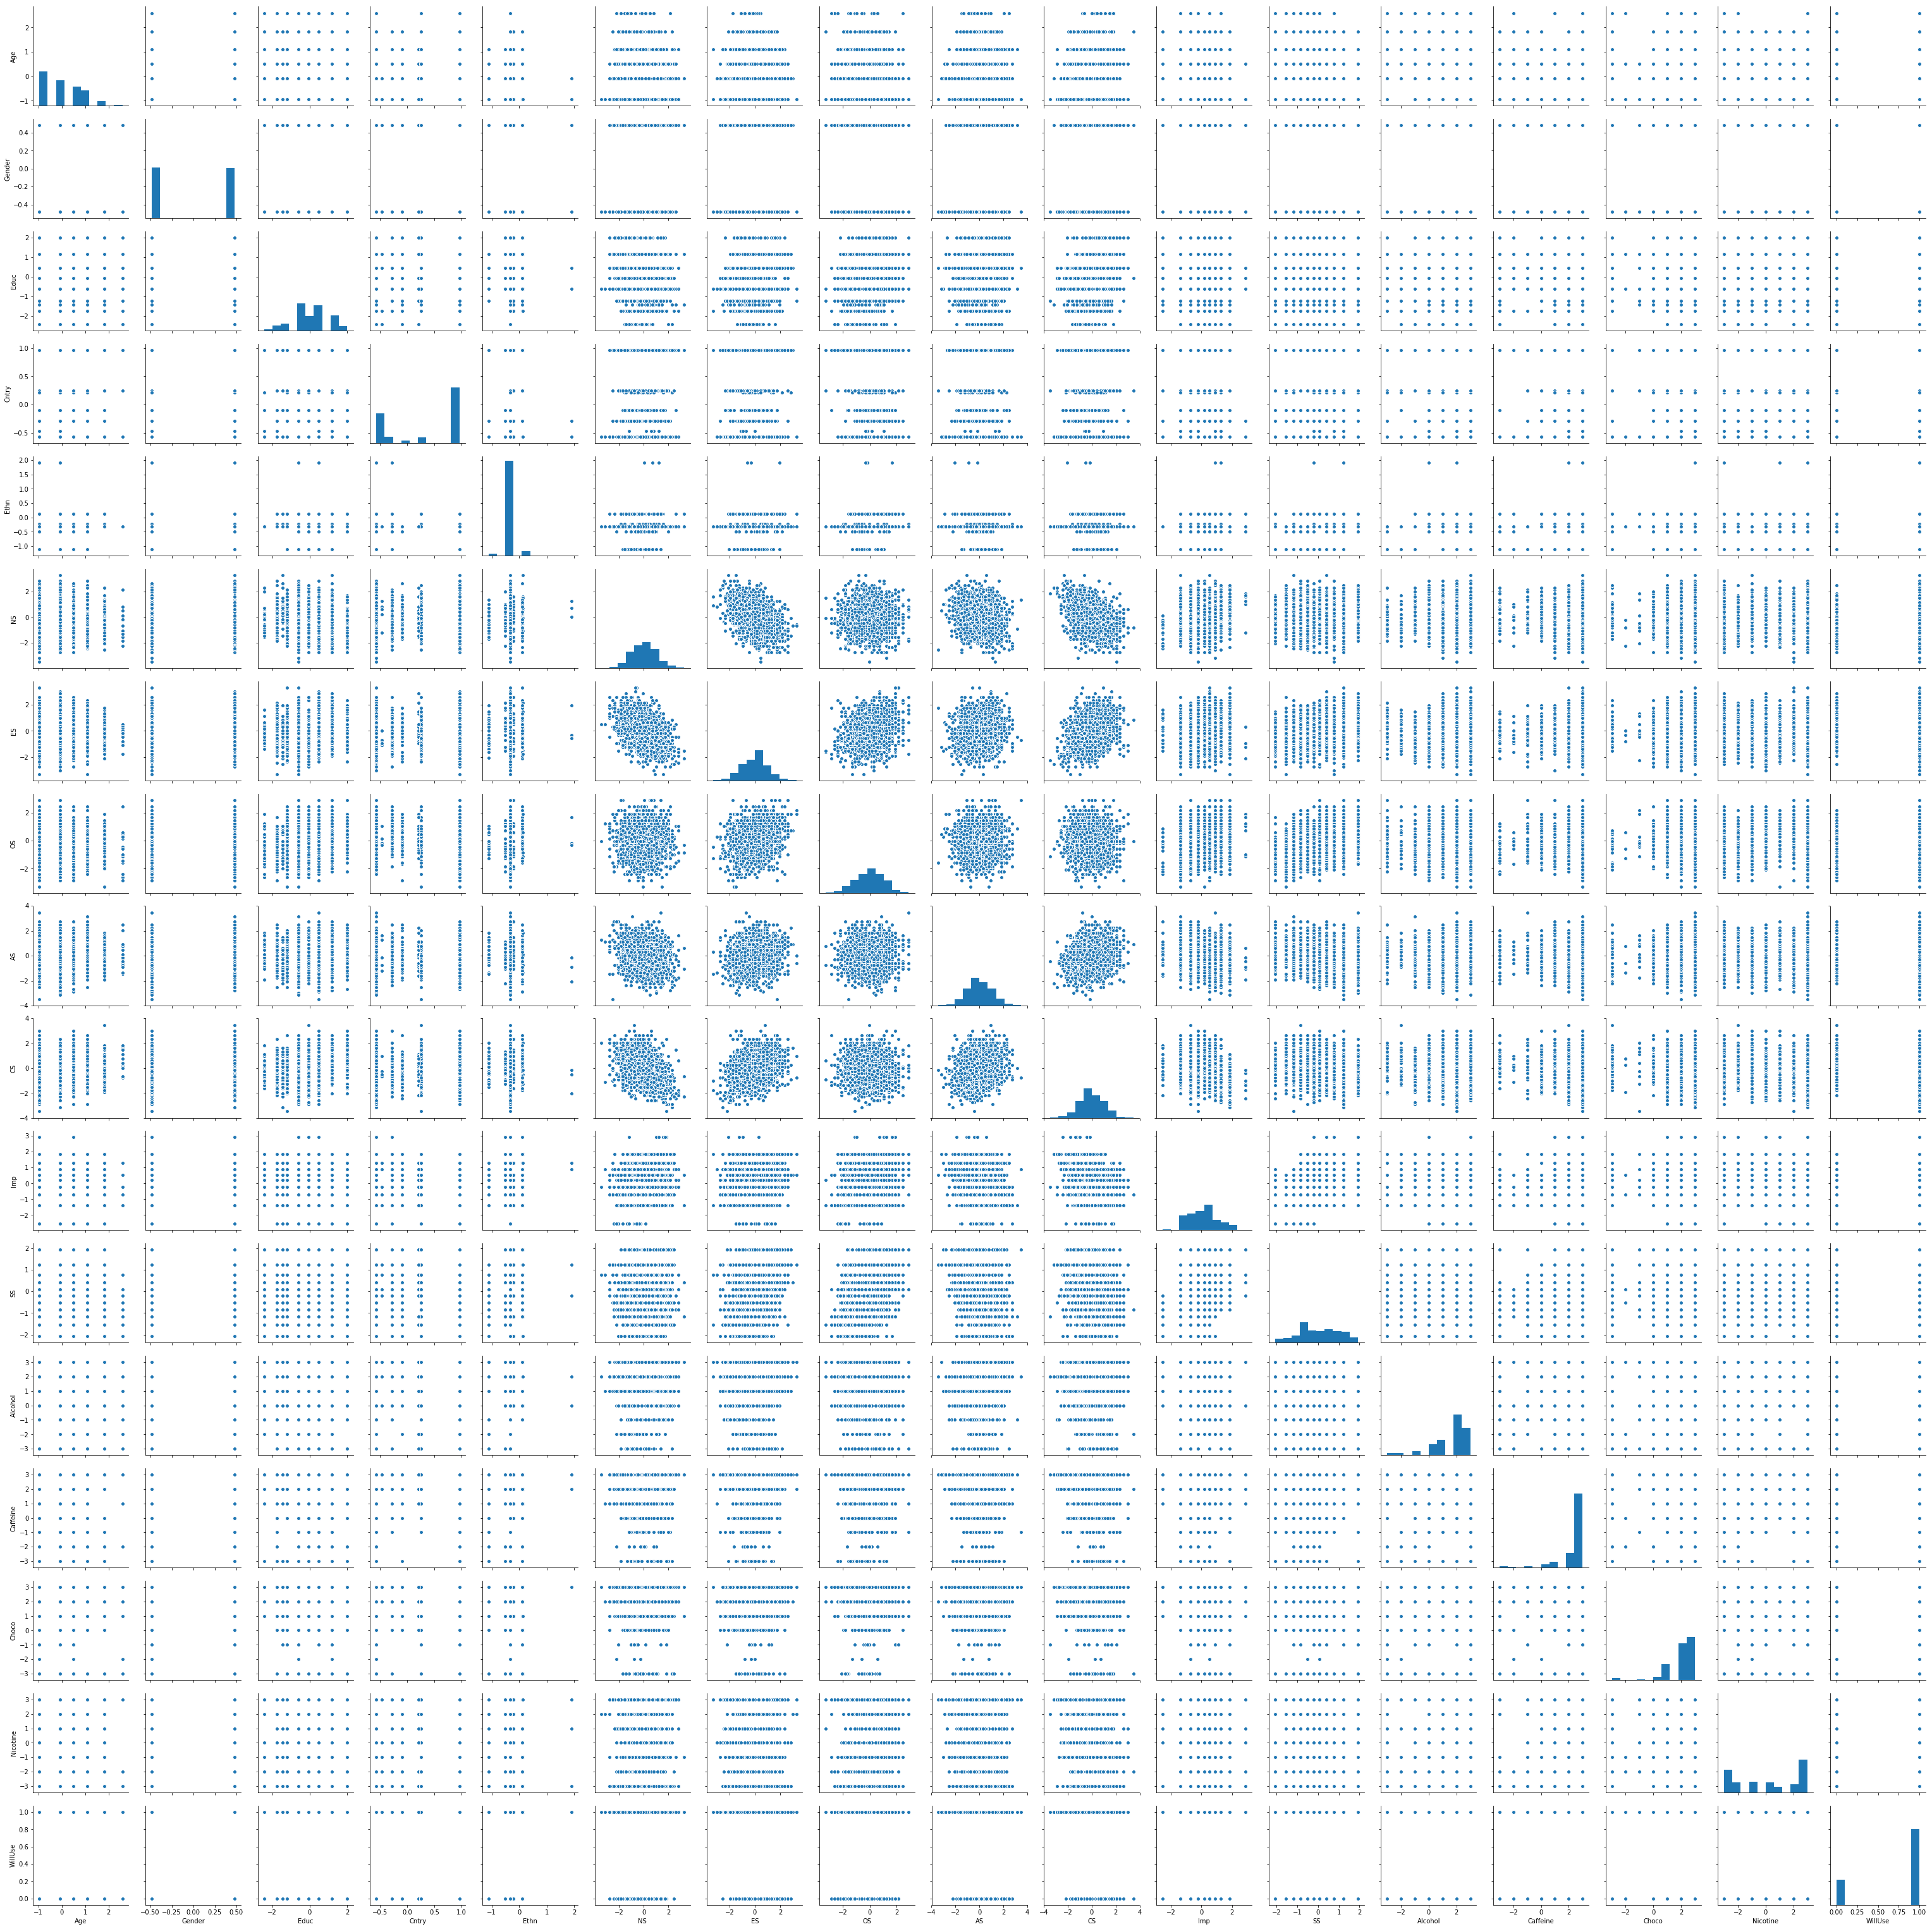

In [21]:
# Maybe a pairplot will help see patterns better?
vis1 = sns.pairplot(data=part_df)

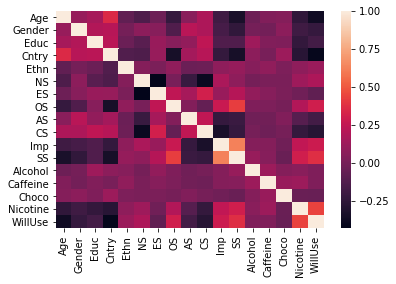

In [22]:
# Correlation heatmap
sns.heatmap(part_df.corr())

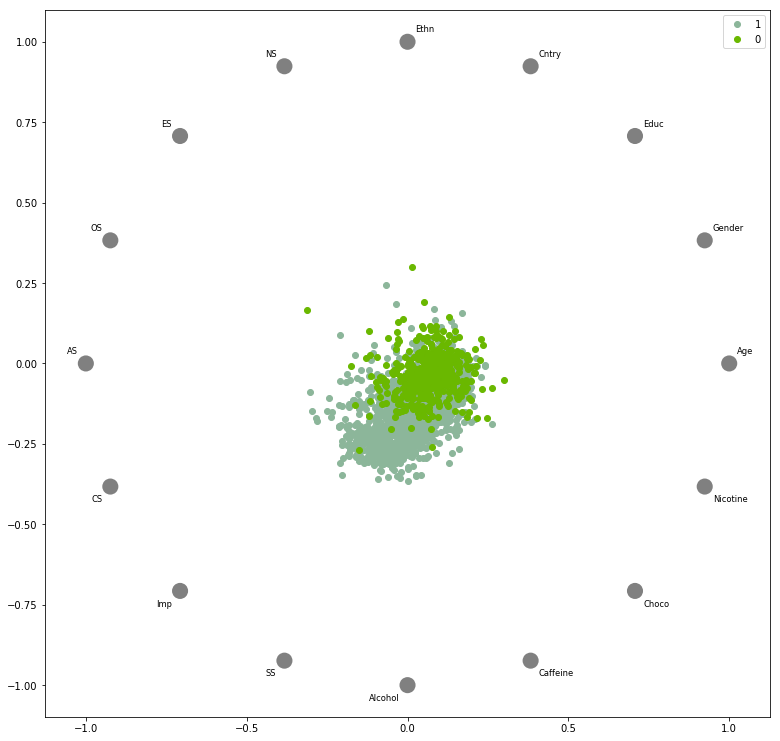

In [23]:
# Interesting - shows greatest correlation between WillUse and Nicotine, SS, Imp and OS-openness to experience

# Create a radial plot focusing on relationships to WillUse
from pandas.plotting import radviz
plt.figure(figsize=(13,13))
pd.plotting.radviz(part_df, "WillUse")
plt.show()

Ah Ha! Look at that! Maybe there's something there? Looks like the blobs are pulled toward Impulsiveness
and Sensation Seeking

### Modeling Phase

In [49]:
# Create arrays to put into the models

X = np.array(part_df[feature_names])
y = np.array(part_df['WillUse'])

In [50]:
# Split the X and y arrays into two equal parts, one to train and one to test
X_train, X_test = X[:942, ...], X[943:, ...]

y_train = y[:942]
y_test = y[943:]

### Random Forest Decision Tree Classifier

In [51]:
# Run the Decisiontree classifier on the train data and test the accuracy using the test data.
dtc = tree.DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)

# Check the accuracy 
accuracy = dtc.score(X_test, y_test)
print("Random Forest Accuracy = ",accuracy)

# Print classification report
target_names = ['Unlikely to Use', 'Will Use']
clr = classification_report(y_test, y_pred, target_names=target_names)
print(clr)

Random Forest Accuracy =  0.8312101910828026
                 precision    recall  f1-score   support

Unlikely to Use       0.60      0.54      0.56       192
       Will Use       0.88      0.91      0.90       750

    avg / total       0.83      0.83      0.83       942



In [52]:
# Function code copied from jhboyle's "1984_Congressional_Voting_Classification  THANKS!
def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 15)
    plt.colorbar()    
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=0, size = 12)
    plt.yticks(tick_marks, target_names, rotation=90, size = 12)
    plt.tight_layout()
    plt.ylabel('True Label', size = 15)
    plt.xlabel('Predicted Label', size = 15)
    plt.savefig('plot_confusion_matrix')

Confusion matrix for un-scaled Random Forest
[[103  89]
 [ 70 680]]


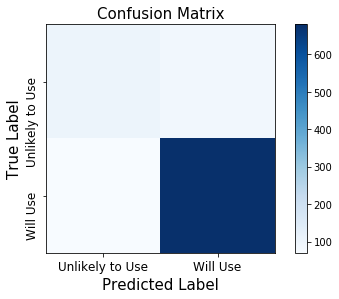

In [53]:
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
print('Confusion matrix for un-scaled Random Forest')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

Normalized Confusion Matrix for Random Forest
[[0.54 0.46]
 [0.09 0.91]]


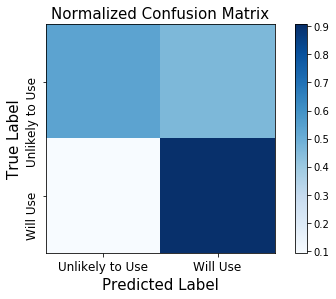

In [54]:
# Following jhboyle's example ...
# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized Confusion Matrix for Random Forest')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized Confusion Matrix')
plt.savefig('plot_norm_confusion_matrix')
plt.show()

In [55]:
# Would it improve the results if I scale X?
Xp = scale(X)

# Split the X array into two, one to train and one to test
Xp_train, Xp_test = Xp[:942, ...], Xp[943:, ...]
y_train = y[:942]
y_test = y[943:]

# Run the Decisiontree classifier on the train data and test the accuracy on the test data.
dtcX = tree.DecisionTreeClassifier()
dtcX.fit(Xp_train, y_train)
y_pred = dtcX.predict(Xp_test)

# Check the accuracy 
accuracy = dtc.score(Xp_test, y_test)
print("Scaled Random Forest Accuracy = ",accuracy)

# Print classification report 
clr = classification_report(y_test, y_pred, target_names=target_names)
print(clr)

Scaled Random Forest Accuracy =  0.7441613588110403
                 precision    recall  f1-score   support

Unlikely to Use       0.56      0.53      0.55       192
       Will Use       0.88      0.89      0.89       750

    avg / total       0.82      0.82      0.82       942



Normalized Confusion Matrix for Scaled Random Forest
[[0.53 0.47]
 [0.11 0.89]]


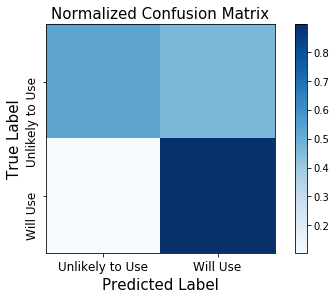

In [57]:
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized Confusion Matrix for Scaled Random Forest')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized Confusion Matrix')
plt.savefig('plot_norm_confusion_matrix')
plt.show()

So far, it's clear that normalizing the confusion matrix helps but scaling the data, not so much

### Gaussian Naive Bayes Classifier

In [59]:
# To try a Naive Bayes model, need to verify the train and test arrays are the same length
print(X_train.shape, y_train.shape)

# Run a Gaussian Naive Bayes model
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

# Print classification report 
clr = classification_report(y_test, y_pred, target_names=target_names)
print(clr)

(942, 16) (942,)
                 precision    recall  f1-score   support

Unlikely to Use       0.62      0.75      0.68       192
       Will Use       0.93      0.88      0.91       750

    avg / total       0.87      0.85      0.86       942



Normalized Confusion Matrix for Naive Bayes
[[0.75 0.25]
 [0.12 0.88]]


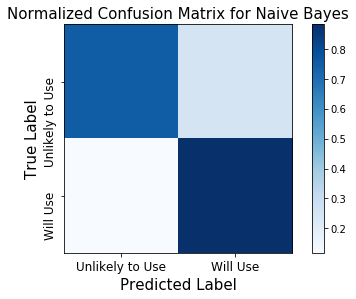

In [61]:
# Plot the normalized confusion matrix
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized Confusion Matrix for Naive Bayes')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized Confusion Matrix for Naive Bayes')
plt.savefig('plot_norm_confusion_matrix')
plt.show()

So, judging from the f1 score, the Naive Bayes is better than the RandomForest, but maybe I can do better still

### K-Nearest Neighbor

In [64]:
# I'll try a K Nearest Neighbor. For this, I'll go back to the scaled training dataset

from sklearn.neighbors import KNeighborsClassifier  
knn = KNeighborsClassifier(n_neighbors=5)  
knn.fit(Xp_train, y_train)
y_pred = knn.predict(Xp_test)

# Print classification report 
clr = classification_report(y_test, y_pred, target_names=target_names)
print(clr)

                 precision    recall  f1-score   support

Unlikely to Use       0.61      0.56      0.59       192
       Will Use       0.89      0.91      0.90       750

    avg / total       0.83      0.84      0.84       942



Normalized Confusion Matrix for K-Nearest Neighbor
[[0.56 0.44]
 [0.09 0.91]]


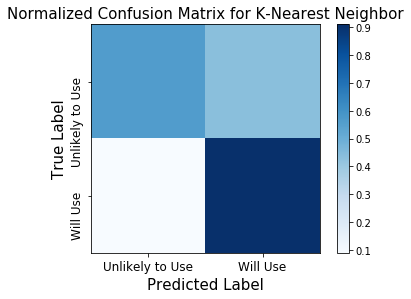

In [65]:
# Plot the normalized confusion matrix
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized Confusion Matrix for K-Nearest Neighbor')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized Confusion Matrix for K-Nearest Neighbor')
plt.savefig('plot_norm_confusion_matrix')
plt.show()

So, judging from the f1 score, kNN isn't as good as the Naive Bayes

### Multi-layer Perceptron Neural Network

In [66]:
# How about a Multi-layer Perceptron neural network model?
from sklearn.neural_network import MLPClassifier

mlpnn = MLPClassifier(solver='sgd', alpha=1e-5, random_state=1)

mlpnn.fit(X_train, y_train)                         
MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='sgd', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)


MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='sgd', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [67]:
# Run the fitted model to get a prediction for the test data
y_pred = mlpnn.predict(X_test)

# Print classification report 
clr = classification_report(y_test, y_pred, target_names=target_names)
print(clr)

                 precision    recall  f1-score   support

Unlikely to Use       0.67      0.62      0.64       192
       Will Use       0.90      0.92      0.91       750

    avg / total       0.86      0.86      0.86       942



Normalized Confusion Matrix
[[0.62 0.38]
 [0.08 0.92]]


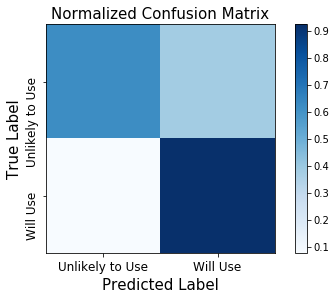

In [68]:
# Plot the normalized confusion matrix
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized Confusion Matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized Confusion Matrix')
plt.savefig('plot_norm_confusion_matrix')
plt.show()

### Adjusting the parameters for the MLPClassifier:

MLP results varied depending on the solver but not other parameters. I started with 'lbfgs', since that's what my example code used. That didn't work very well (f1-score 0.82), so on the advice of stackoverflow, I tried 'sgd', giving f1-score 0.86. I tried the 'adam' solver but I got a warning that it wasn't converging.  I gave it four hidden layers but that didn't help. Going back to the 'sgd solver, I also adjusted the number of hidden layers a few times, going up to four, but f1 stayed the same. I doubled the number of iterations to 400, which also had no effect on f1, so I set 'sgd' back to one hidden layer and 200 iterations.

### So far, the Naive Bayes and Perceptron are best and give comparable results

### Read in a totally new dataset from a different study to exercise the Naive Bayes

This dataset was built around data taken from John Anthony Johnson's IPIP-NEO data repository, using results from his 2005 JRP study. The Notebook used to create the dataset is called "Reading & Wrangling Diff Dataset for Drug Use Predictor" and added random integers to his actual data to provide all needed features

In [82]:
new_df = pd.read_csv('data/Johnny_data_out.csv') 
new_df.head()

,ID,Age,Gender,NS,ES,OS,AS,CS,Imp,SS,Cntry,Educ,Ethn,Alcohol,Caffeine,Choco,Nicotine
0,-3.000000,-0.975,3.0,-1.479638,-0.781991,1.581818,0.807107,2.098446,0.384615,-2.25,3,-5.645804,0.215944,-4.067063,-2.587810,-6.358964,-3.020073
1,-2.998105,-1.425,3.0,-1.262443,-0.668246,1.763636,1.934010,0.606218,-2.692308,-0.30,3,-5.277698,-0.362967,1.074094,-5.133310,-5.432314,-2.659044
2,-2.996210,-1.950,3.0,-1.343891,-0.696682,0.781818,1.324873,1.414508,-0.692308,-2.10,3,-4.240410,-3.942407,-1.748614,-1.051587,-1.641847,-0.847732
3,-2.994315,-2.025,3.0,-0.502262,1.578199,0.636364,2.025381,-0.948187,1.307692,1.50,3,-3.826204,-3.179433,-3.146491,1.163935,-4.050523,0.469662
4,-2.992419,-1.275,3.0,0.257919,0.099526,0.890909,1.507614,0.979275,-0.076923,-0.90,3,-3.925584,-3.123761,-8.420627,-8.005182,-2.852458,-4.888982


In [83]:
# I'll try the Naive Bayes since the MLP had trouble converging under certain conditions
# and throwing in a bunch of random data won't help

# Create array to put into the model
X_new = np.array(new_df[feature_names])

# Run the Gaussian Naive Bayes model, fitting it again with the UCI data
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_new)

In [84]:
from scipy import stats
stats.describe(y_pred)

DescribeResult(nobs=3167, minmax=(0, 1), mean=0.16892958635933059, variance=0.14043672498349913, skewness=1.7671710855001974, kurtosis=1.122893645427947)

In [86]:
# That's not very helpful. I like df.describe better
dfy = pd.DataFrame(y_pred)
print(dfy.describe())  

                 0
count  3167.000000
mean      0.168930
std       0.374749
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


### Final Assessment

Hmmmm. With such a low mean, it suggests the people in the new sample are much less likely to use illegal drugs than the people in the UCI sample. Is that realistic? Such a big difference?
- UCI WillUse mean = 0.75 (or about 75% WillUse)
- Johnny's data mean = 0.16 (or only about 16% WillUse)

### Maybe the Drug Use Predictor isn't much good when you use random numbers for half the features?

### Or maybe the Drug Use Predictor just isn't good?